# Lab 09-1: AlexNet for ImageNet Challenge (ILSVRC)
## Exercise: Image Classification

Load Libraries

In [9]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  0


Prepare Datasets

In [10]:
dataset = 'cifar10'

if dataset == 'cifar10':
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
elif dataset == 'imagenette':
    # Imagenette is a subset of 10 easily classified classes from Imagenet 
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'test': <tfds.core.SplitInfo num_examples=10000>, 'train': <tfds.core.SplitInfo num_examples=50000>}
50000


In [11]:
n_channels = ds_info.features['image'].shape[-1]

if dataset == 'imagenette':
    classes = ['tench', 'English springer', 'cassette player', 'chain saw', 
               'church', 'French horn', 'garbage truck', 'gas pump', 
               'golf ball', 'parachute']
else:
    classes = ds_info.features['label'].names
n_classes = ds_info.features['label'].num_classes

n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

40000 10000 10000


Show a Sample Data

Image demension: (32, 32, 3) , label: 6


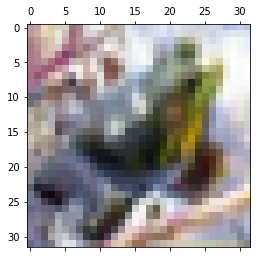

The picture is frog


In [12]:
idx = np.random.randint(n_train-1)

for element in ds_train.skip(idx).take(1):
    image, label = element

print('Image demension:', image.shape, ', label:',label.numpy())

dimage = tf.reshape(image, image.shape) 
plt.matshow(dimage)
plt.show()
print('The picture is', classes[label])

Building Input Data Pipelines

In [13]:
def tfds_4_NET(image, label):

    image = tf.image.resize((image / 255), [227,227], method='bilinear')
    label = tf.one_hot(label, n_classes) 

    return image, label

In [14]:
n_batch = 64

dataset = ds_train.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

valiset = ds_val.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

testset = ds_test.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

### Network Definition of AlexNet with Keras Sequential API



In [15]:
# model
AlexNet = tf.keras.Sequential([
    ### START CODE HERE ###

    # Input Layer
    tf.keras.layers.InputLayer(input_shape=(227,227,3)),

    # Layer 1
    tf.keras.layers.Conv2D(96, 11, strides=(4,4), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),

    # Layer 2
    tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),

    # Layer 3 to 5
    tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    tf.keras.layers.Flatten(),

    # Layer 6 to 8
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')    
    
    ### END CODE HERE ###
])

AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

### Training the Model

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
AlexNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [17]:
n_epochs = 10

results = AlexNet.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                   validation_data=valiset, validation_batch_size=n_batch,
                   verbose=1)

Epoch 1/10
357/625 [================>.............] - ETA: 37:34 - loss: 2.8639 - acc: 0.2217

KeyboardInterrupt: ignored

Plot Convergence Graph

In [ ]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['acc'], 'g-', label='accuracy')
plt.plot(results.history['val_acc'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate Model Performance

In [ ]:
AlexNet.evaluate(testset)

### Test Model with a Random Sample


In [ ]:
idx = np.random.randint(n_test-1)

for element in ds_test.skip(idx).take(1):
    img, lbl = element
    X_test, y_test = tfds_4_NET(img, lbl)

X_test = tf.expand_dims(X_test, axis=0)

dimage = np.array(X_test[0])
plt.matshow(dimage)
plt.show()

outt_4 = AlexNet.predict(X_test)
p_pred = np.argmax(outt_4, axis=-1)

print('My prediction is ' + classes[p_pred[0]])
print('Actual image is  ' + classes[tf.argmax(y_test, -1)])